# Homework 5 - Independent Component Analysis

Brennan McFarland  
bfm21

Exercise 1: Write a gradient-based algorithm to learn the independent components, i.e. the mixing matrix,
given a matrix where the rows contain samples from different sources.

## Learning Independent Components

## Verifying on a Synthetic Mixture

### Loading the Data

In [14]:
import csv, numpy as np
with open('data/testdata.txt', 'rt') as csvfile:
    dataReader = csv.reader(csvfile, delimiter=' ')
    # initialize an empty array
    data = []
    for row in dataReader:
        data.append(np.array(row).astype(np.float))
    # convert data into a numpy array
    data = np.asarray(data)

### Initializing the Mixture Model

In [15]:
# randomly pick coordinates as center of Gaussian distribution
def randinitMean(n, drange):
    mu = []
    for m in range(n):
        mu.append([np.random.uniform(drange[i]['MIN'], drange[i]['MAX']) for i in range(len(drange))])
    # return inf form of numpy.ndarray
    return np.asarray(mu)

def randOrthogonalMatrix(ndim):
    ortmat = np.random.normal(size=[ndim,ndim])
    for i in range(ndim):
        # remove components exist in vector before
        r = ortmat[:,i]
        if i > 0:
            b = ortmat[:,range(i)]
            r = r - b.dot(b.T.dot(r))
        # normalize current column
        ortmat[:,i] = r / np.sqrt(r.T.dot(r))
    return ortmat

def randinitCovarianceND(n, ndim=2):
    sigma = []
    for m in range(n):
        # create eigen vectors as an orthogonal matrix
        eigenVector = randOrthogonalMatrix(ndim)
        # randomly positive values as eigen value
        eigenValue = abs(np.random.normal(size=ndim))
        # compose covariance matrix
        sigma.append(eigenVector.T.dot(np.diag(eigenValue).dot(eigenVector)))
    return np.asarray(sigma)

In [16]:
ngmm = 2 # quantity of Gaussian Mixture Model
ndim = 2 # TODO: not exactly sure what this does, find out?

# get information of range on each dimension
dataRange = []
for i in range(data.shape[1]):
    dataRange.append({'MIN': min(data[:,i]), 'MAX': max(data[:,i])})
    
mu = randinitMean(ngmm, dataRange)

sigma = randinitCovarianceND(ngmm, ndim)
def covmatIsLegal(sigma):
    for covmat in sigma:
        if not(np.allclose(covmat, covmat.T)) or np.any(np.linalg.eigvals(covmat) <= 0):
            return False
    return True

print("Convariance Matrices are Legal? : %r" % covmatIsLegal(sigma))
gmm = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

Convariance Matrices are Legal? : True


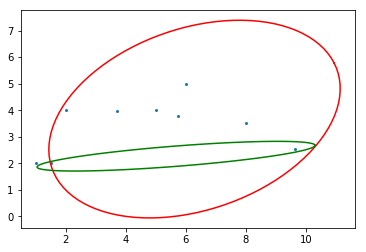

In [17]:
import matplotlib.pyplot as plt
from scipy.stats import chi2
def plotGaussianModel2D(mu, sigma, pltopt='k'):
    if sigma.any():
        # calculate ellipse constants
        c = chi2.ppf(0.9, 2) # use confidence interval 0.9
        # get eigen vector and eigen values
        eigenValue, eigenVector = np.linalg.eig(sigma)
        # calculate points on ellipse
        t = np.linspace(0, 2*np.pi, 100) # draw 100 points
        u = [np.cos(t), np.sin(t)]
        w = c * eigenVector.dot(np.diag(np.sqrt(eigenValue)).dot(u))
        z = w.T + mu
    else:
        z = mu
    # plot ellipse by connecting sample points on curve
    plt.plot(z[:,0], z[:,1], pltopt)
    
def colorPicker(index):
    colors = 'rgbcmyk'
    return colors[np.remainder(index, len(colors))]

def gmmplot(data, gmm):
    # plot data points
    plt.scatter(data[:, 0], data[:, 1], s=4)
    # plot Gaussian model
    color = 'rgb'
    for index, model in enumerate(gmm):
        plotGaussianModel2D(model['mean'], model['covariance'], colorPicker(index))

gmmplot(data, gmm)